# Get collected closed shell data

In [1]:
import sys
sys.path.insert(0,"/home/gridsan/hwpang/Software/RMG-Py/")
sys.path.insert(0,"..")

import string
import random
import os
import time
import math
from copy import deepcopy
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import Parallel, delayed
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from rmgpy.data.thermo import ThermoDatabase, ThermoLibrary, ThermoData, remove_thermo_data, add_thermo_data, NASA
from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy import settings
from rmgpy import constants

from tree.utils import load_thermo_lib_by_path, generate_thermo, make_mol
from tree.parameters import Ts, columns


# Extract closed shell data into DataFrame

In [2]:
lib_paths = [
    "../data/dong_pio_liang.py",
    "../data/pang.py",
    "../data/johnson_cbs-qb3.py",
    "../data/johnson_g4.py",
]

In [3]:
# load thermo database

thermo_database = ThermoDatabase()
thermo_database.load_groups(os.path.join(settings["database.directory"], "thermo", "groups"))
for path in lib_paths:
    load_thermo_lib_by_path(path, thermo_database)
    thermo_database.library_order.remove(path)
thermo_database.library_order = lib_paths + thermo_database.library_order

The thermodynamics library ../data/dong_pio_liang.py is loaded.
The thermodynamics library ../data/pang.py is loaded.
The thermodynamics library ../data/johnson_cbs-qb3.py is loaded.
The thermodynamics library ../data/johnson_g4.py is loaded.


In [4]:
temp_dict = {
    "smiles": [],
    "H298 (kcal/mol)": [],
    "S298 (cal/mol/K)": [],
    "Sint298 (cal/mol/K)": [],
    "source": [],
    "level_of_theory": []
}

for T in Ts:
    temp_dict[f"Cp{T} (cal/mol/K)"] = []

for lib_path in lib_paths:
    lib = thermo_database.libraries[lib_path]
    for entry in lib.entries.values():
        if (not entry.item.is_radical()) and (entry.item.multiplicity==1) and (not "[" in entry.item.to_smiles()):
            closed_shell = deepcopy(entry.item)
            closed_shell_data = deepcopy(entry.data)
            closed_shell.atoms.sort()

            temp_dict["smiles"].append(closed_shell.to_smiles())
            temp_dict["source"].append(os.path.basename(lib_path))
            if lib_path == "../data/johnson_g4.py":
                    level_of_theory = "G4"
            else:
                level_of_theory = "CBS-QB3"
            temp_dict["level_of_theory"].append(level_of_theory)
            
            closed_shell_data.Cp0 = (closed_shell.calculate_cp0(), "J/(mol*K)")
            closed_shell_data.CpInf = (closed_shell.calculate_cpinf(), "J/(mol*K)")
            if not isinstance(closed_shell_data, ThermoData):
                closed_shell_data = closed_shell_data.to_thermo_data()
                
            temp_dict["H298 (kcal/mol)"].append(closed_shell_data.H298.value_si/1000/4.184)
            temp_dict["S298 (cal/mol/K)"].append(closed_shell_data.S298.value_si/4.184)
            for Cp, T in zip(closed_shell_data.Cpdata.value_si, Ts):
                temp_dict[f"Cp{T} (cal/mol/K)"].append(Cp/4.184)
            
            #remove entropy correction
            closed_shell_data.S298.value_si += constants.R * math.log(closed_shell.get_symmetry_number())
            temp_dict["Sint298 (cal/mol/K)"].append(closed_shell_data.S298.value_si/4.184)
            
closed_shell_data_df = pd.DataFrame(temp_dict)
closed_shell_data_df

,smiles,H298 (kcal/mol),S298 (cal/mol/K),Sint298 (cal/mol/K),source,level_of_theory,Cp300 (cal/mol/K),Cp400 (cal/mol/K),Cp500 (cal/mol/K),Cp600 (cal/mol/K),Cp800 (cal/mol/K),Cp1000 (cal/mol/K),Cp1500 (cal/mol/K)
0,OCCO,-91.475141,74.505005,75.882432,dong_pio_liang.py,CBS-QB3,19.772015,23.312155,26.574813,29.528059,34.418725,38.150530,43.975543
1,CCOOCO,-83.631371,90.666732,92.849902,dong_pio_liang.py,CBS-QB3,30.201229,35.932398,41.053196,45.468650,52.490578,57.565100,64.761116
2,CC(=O)OC(OO)C(C)C,-148.023740,113.279985,118.452067,dong_pio_liang.py,CBS-QB3,48.900129,59.503184,68.436976,75.856609,86.934270,94.574118,105.695451
3,CC1OC1(O)C=O,-97.936286,84.799082,86.982251,dong_pio_liang.py,CBS-QB3,29.080761,36.341057,41.919758,46.394705,53.174298,57.690274,63.111820
4,OCC1OC1O,-107.024591,79.286937,79.286937,dong_pio_liang.py,CBS-QB3,27.160608,34.526171,40.331379,44.462760,49.882581,53.246324,56.984775
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,CC(COCOO)OO,-111.105225,109.769585,110.575328,johnson_g4.py,G4,45.020652,56.239615,65.534984,73.130573,84.097754,90.740320,96.733530
1216,CC(COO)OO,-66.673304,102.503237,103.308980,johnson_g4.py,G4,39.750109,44.554189,49.013203,52.888382,59.089448,63.615498,70.157006
1217,CCCOCOO,-84.835720,91.598614,93.781784,johnson_g4.py,G4,36.036397,43.031307,49.329967,54.767777,63.433207,69.715775,78.679666
1218,CCC(OO)OCOO,-117.715158,103.213597,104.019340,johnson_g4.py,G4,46.980982,56.563666,64.555441,71.150159,80.863725,87.010353,93.543021


In [5]:
closed_shell_data_df = closed_shell_data_df.sort_values("H298 (kcal/mol)", ascending=True)
closed_shell_data_df = closed_shell_data_df.drop_duplicates(subset=["smiles"], keep="first")
closed_shell_data_df = closed_shell_data_df.reset_index(drop=True)
closed_shell_data_df

,smiles,H298 (kcal/mol),S298 (cal/mol/K),Sint298 (cal/mol/K),source,level_of_theory,Cp300 (cal/mol/K),Cp400 (cal/mol/K),Cp500 (cal/mol/K),Cp600 (cal/mol/K),Cp800 (cal/mol/K),Cp1000 (cal/mol/K),Cp1500 (cal/mol/K)
0,O=C(O)OC(=O)O,-223.695934,86.503270,87.880696,dong_pio_liang.py,CBS-QB3,24.694823,28.758100,32.040339,34.628195,38.156001,40.350524,43.222983
1,O=C(O)OOC(=O)O,-207.561438,89.677636,89.677636,dong_pio_liang.py,CBS-QB3,31.477679,35.532436,38.839088,41.539828,45.440842,47.813838,50.045646
2,O=C(O)OC(=O)OO,-199.973245,94.255903,94.255903,dong_pio_liang.py,CBS-QB3,31.001150,34.739959,37.826260,40.355462,44.035249,46.312523,48.616051
3,OC(O)(O)O,-198.154401,73.667101,78.605124,dong_pio_liang.py,CBS-QB3,24.528553,28.376019,30.634631,32.364126,35.043094,36.927293,39.689158
4,CC(=O)OC(O)=C(O)C=O,-190.868747,99.627504,101.810673,dong_pio_liang.py,CBS-QB3,38.185218,46.700740,54.199505,60.666495,70.579698,76.858689,83.009990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,C#CC#CC,99.166742,70.169077,72.352246,dong_pio_liang.py,CBS-QB3,21.352456,24.860022,27.836934,30.432865,34.643101,37.788097,42.576978
1184,C#CCCC#C,100.941544,78.794535,80.171962,dong_pio_liang.py,CBS-QB3,27.660381,32.720251,36.858309,40.447492,46.220453,50.481963,56.869145
1185,C#CCC=C=C,101.236704,81.736426,81.736426,dong_pio_liang.py,CBS-QB3,26.250813,31.369646,35.807317,39.637328,45.746375,50.196763,56.711522
1186,C1=CC2=CC2C1,110.044827,72.024033,72.024033,dong_pio_liang.py,CBS-QB3,21.242174,28.205640,34.043610,38.639941,45.736891,50.800160,57.823342


In [6]:
closed_shell_data_df.to_csv("../data/all_closed_shell_data.csv", index=False)

# Estimate GAV for closed shells

In [7]:
closed_shell_data_df = pd.read_csv("../data/all_closed_shell_data.csv")

In [8]:
# load thermo database

thermo_database = ThermoDatabase()
thermo_database.load_groups(os.path.join(settings["database.directory"], "thermo", "groups"))

In [9]:
generate_thermo(thermo_database, "O=C(O)OC(=O)O", resonance=True) # we want the best thermo estimation

/home/gridsan/hwpang/Software/RMG-Py/rmgpy/rmg/reactors.py:52: RuntimeWarning: Unable to import Julia dependencies, original error: No module named 'julia'
  warnings.warn("Unable to import Julia dependencies, original error: " + str(e), RuntimeWarning)


(-224.5697896749522,
 88.67037456389947,
 array([26.02294455, 31.01099426, 34.69646272, 37.19407266, 39.80640535,
        40.77198853, 41.6085086 ]),
 90.04780114722755,
 'Thermo group additivity estimation: group(O2s-(Cds-O2d)(Cds-O2d)) + group(O2s-(Cds-O2d)H) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Cds-OdOsOs)')

In [10]:
closed_shell_gav_df = closed_shell_data_df[["smiles"]]
thermos = closed_shell_gav_df["smiles"].apply(lambda smi: generate_thermo(thermo_database, smi, resonance=True))

In [11]:
temp_columns = ["H298 (kcal/mol)", "S298 (cal/mol/K)", "Cp (cal/mol/K)", "Sint298 (cal/mol/K)", "comment"]
closed_shell_gav_df[temp_columns] = thermos.to_list()

temp_columns = []
for i, T in enumerate(Ts):
    temp_columns.append(f"Cp{T} (cal/mol/K)")
closed_shell_gav_df[temp_columns] = closed_shell_gav_df["Cp (cal/mol/K)"].to_list()

closed_shell_gav_df = closed_shell_gav_df.drop("Cp (cal/mol/K)", axis=1)

temp_columns = closed_shell_gav_df.columns.tolist()
temp_columns.remove("comment")
temp_columns.append("comment")

closed_shell_gav_df = closed_shell_gav_df[temp_columns]

closed_shell_gav_df

/home/gridsan/hwpang/mambaforge/envs/rmg_rdmc_env_20230623_v2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/home/gridsan/hwpang/mambaforge/envs/rmg_rdmc_env_20230623_v2/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,smiles,H298 (kcal/mol),S298 (cal/mol/K),Sint298 (cal/mol/K),Cp300 (cal/mol/K),Cp400 (cal/mol/K),Cp500 (cal/mol/K),Cp600 (cal/mol/K),Cp800 (cal/mol/K),Cp1000 (cal/mol/K),Cp1500 (cal/mol/K),comment
0,O=C(O)OC(=O)O,-224.56979,88.670375,90.047801,26.022945,31.010994,34.696463,37.194073,39.806405,40.771989,41.608509,Thermo group additivity estimation: group(O2s-...
1,O=C(O)OOC(=O)O,-253.919924,88.956138,88.956138,28.685239,38.290478,44.610593,48.464971,53.013078,54.366233,54.925507,Thermo group additivity estimation: group(O2s-...
2,O=C(O)OC(=O)OO,-205.306042,97.035602,97.035602,32.525105,37.608681,40.983193,43.009216,44.614034,44.930784,45.801587,Thermo group additivity estimation: group(O2s-...
3,OC(O)(O)O,-180.93499,79.310773,84.248795,22.561358,25.059254,27.183078,28.799426,31.689484,34.004818,38.507686,Thermo group additivity estimation: group(O2s-...
4,CC(=O)OC(O)=C(O)C=O,-192.700554,104.698379,106.881549,43.483461,52.370937,58.163518,62.185411,68.223461,72.041205,76.271587,Thermo group additivity estimation: group(O2s-...
...,...,...,...,...,...,...,...,...,...,...,...,...
1183,C#CC#CC,95.48,71.036831,73.22,21.680000,25.430000,28.500000,31.030000,35.090000,38.110000,43.920000,Thermo group additivity estimation: group(Cs-C...
1184,C#CCCC#C,99.5,81.322573,82.7,26.720000,32.060000,36.460000,40.080000,45.860000,50.140000,58.800000,Thermo group additivity estimation: group(Cs-C...
1185,C#CCC=C=C,101.146874,60.284685,60.284685,24.704919,30.112266,34.543461,38.258145,43.900263,47.894044,54.111950,Thermo group additivity estimation: group(Cs-(...
1186,C1=CC2=CC2C1,91.842112,63.923015,63.923015,24.835180,30.833315,36.215700,40.622881,47.099212,51.758989,58.004231,Thermo group additivity estimation: group(Cs-(...


In [12]:
closed_shell_gav_df.to_csv("../data/all_closed_shell_gav.csv", index=False)

# Plot: GAV vs. QM for closed shells

In [13]:
closed_shell_data_df = pd.read_csv("../data/all_closed_shell_data.csv")
closed_shell_gav_df = pd.read_csv("../data/all_closed_shell_gav.csv")

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
ax = axs.flat[0]
errors = closed_shell_gav_df["H298 (kcal/mol)"] - closed_shell_data_df["H298 (kcal/mol)"]
ax.hist(errors, bins=50)
ax.set_title("(a) $\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

ax = axs.flat[1]
errors = closed_shell_gav_df["S298 (cal/mol/K)"] - closed_shell_data_df["S298 (cal/mol/K)"]
ax.hist(errors, bins=50)
ax.set_title("(b) $S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
    errors = closed_shell_gav_df[f"Cp{T} (cal/mol/K)"] - closed_shell_data_df[f"Cp{T} (cal/mol/K)"]
    ax.hist(errors, bins=50)
    ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

fig.supylabel(f"Count (N={len(closed_shell_data_df.index)})")
fig.supxlabel(f"Error (GAV - QM)")

fig.tight_layout()
fig.savefig("../figures/data_all_closed_shell_gav_error_hist.pdf", bbox_inches="tight")

In [21]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
ax = axs.flat[0]
true_ys = closed_shell_data_df["H298 (kcal/mol)"]
pred_ys = closed_shell_gav_df["H298 (kcal/mol)"]
min_y = min(true_ys.min(), pred_ys.min())
max_y = max(true_ys.max(), pred_ys.max())
rmse = np.sqrt(mean_squared_error(true_ys, pred_ys))
mae = mean_absolute_error(true_ys, pred_ys)
r2 = r2_score(true_ys, pred_ys)
ax.scatter(true_ys, pred_ys, alpha=0.5)
ax.plot([min_y, max_y], [min_y, max_y], "k--")
ax.text(0.1, 0.9, f"""RMSE: {rmse:.2f}
MAE: {mae:.2f}
R$^2$: {r2:.2f}""", ha="left", va="top", transform=ax.transAxes)
ax.set_title("(a) $\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

ax = axs.flat[1]
true_ys = closed_shell_data_df["S298 (cal/mol/K)"]
pred_ys = closed_shell_gav_df["S298 (cal/mol/K)"]
min_y = min(true_ys.min(), pred_ys.min())
max_y = max(true_ys.max(), pred_ys.max())
rmse = np.sqrt(mean_squared_error(true_ys, pred_ys))
mae = mean_absolute_error(true_ys, pred_ys)
r2 = r2_score(true_ys, pred_ys)
ax.scatter(true_ys, pred_ys, alpha=0.5)
ax.plot([min_y, max_y], [min_y, max_y], "k--")
ax.text(0.1, 0.9, f"""RMSE: {rmse:.2f}
MAE: {mae:.2f}
R$^2$: {r2:.2f}""", ha="left", va="top", transform=ax.transAxes)
ax.set_title("(b) $S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
    true_ys = closed_shell_data_df[f"Cp{T} (cal/mol/K)"]
    pred_ys = closed_shell_gav_df[f"Cp{T} (cal/mol/K)"]
    min_y = min(true_ys.min(), pred_ys.min())
    max_y = max(true_ys.max(), pred_ys.max())
    rmse = np.sqrt(mean_squared_error(true_ys, pred_ys))
    mae = mean_absolute_error(true_ys, pred_ys)
    r2 = r2_score(true_ys, pred_ys)
    ax.scatter(true_ys, pred_ys, alpha=0.5)
    ax.plot([min_y, max_y], [min_y, max_y], "k--")
    ax.text(0.1, 0.9, f"""RMSE: {rmse:.2f}
MAE: {mae:.2f}
R$^2$: {r2:.2f}""", ha="left", va="top", transform=ax.transAxes)
    ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

fig.supylabel(f"GAV")
fig.supxlabel(f"QM")

fig.tight_layout()
fig.savefig("../figures/data_all_closed_shell_gav_qm_parity.pdf", bbox_inches="tight")


# Inspect species with large error in GAV

In [16]:
closed_shell_data_df = pd.read_csv("../data/all_closed_shell_data.csv")
closed_shell_gav_df = pd.read_csv("../data/all_closed_shell_gav.csv")

In [17]:
columns

['H298 (kcal/mol)',
 'S298 (cal/mol/K)',
 'Sint298 (cal/mol/K)',
 'Cp300 (cal/mol/K)',
 'Cp400 (cal/mol/K)',
 'Cp500 (cal/mol/K)',
 'Cp600 (cal/mol/K)',
 'Cp800 (cal/mol/K)',
 'Cp1000 (cal/mol/K)',
 'Cp1500 (cal/mol/K)']

In [18]:
error_df = closed_shell_gav_df[["smiles", "comment"]]
error_df["source"] = closed_shell_data_df["source"]
error_df[columns] = closed_shell_gav_df[columns] - closed_shell_data_df[columns]
error_df

/home/gridsan/hwpang/mambaforge/envs/rmg_rdmc_env_20230623_v2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/gridsan/hwpang/mambaforge/envs/rmg_rdmc_env_20230623_v2/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,smiles,comment,source,H298 (kcal/mol),S298 (cal/mol/K),Sint298 (cal/mol/K),Cp300 (cal/mol/K),Cp400 (cal/mol/K),Cp500 (cal/mol/K),Cp600 (cal/mol/K),Cp800 (cal/mol/K),Cp1000 (cal/mol/K),Cp1500 (cal/mol/K)
0,O=C(O)OC(=O)O,Thermo group additivity estimation: group(O2s-...,dong_pio_liang.py,-0.873856,2.167105,2.167105,1.328122,2.252894,2.656124,2.565878,1.650404,0.421464,-1.614475
1,O=C(O)OOC(=O)O,Thermo group additivity estimation: group(O2s-...,dong_pio_liang.py,-46.358485,-0.721499,-0.721499,-2.792440,2.758042,5.771505,6.925143,7.572236,6.552395,4.879861
2,O=C(O)OC(=O)OO,Thermo group additivity estimation: group(O2s-...,dong_pio_liang.py,-5.332797,2.779699,2.779699,1.523956,2.868722,3.156933,2.653754,0.578786,-1.381739,-2.814464
3,OC(O)(O)O,Thermo group additivity estimation: group(O2s-...,dong_pio_liang.py,17.219411,5.643672,5.643672,-1.967196,-3.316764,-3.451552,-3.564700,-3.353611,-2.922474,-1.181472
4,CC(=O)OC(O)=C(O)C=O,Thermo group additivity estimation: group(O2s-...,dong_pio_liang.py,-1.831807,5.070876,5.070876,5.298243,5.670197,3.964013,1.518916,-2.356238,-4.817484,-6.738403
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,C#CC#CC,Thermo group additivity estimation: group(Cs-C...,dong_pio_liang.py,-3.686742,0.867754,0.867754,0.327544,0.569978,0.663066,0.597135,0.446899,0.321903,1.343022
1184,C#CCCC#C,Thermo group additivity estimation: group(Cs-C...,dong_pio_liang.py,-1.441544,2.528038,2.528038,-0.940381,-0.660251,-0.398309,-0.367492,-0.360453,-0.341963,1.930855
1185,C#CCC=C=C,Thermo group additivity estimation: group(Cs-(...,dong_pio_liang.py,-0.089830,-21.451742,-21.451742,-1.545894,-1.257381,-1.263856,-1.379182,-1.846112,-2.302719,-2.599571
1186,C1=CC2=CC2C1,Thermo group additivity estimation: group(Cs-(...,dong_pio_liang.py,-18.202715,-8.101018,-8.101018,3.593006,2.627676,2.172090,1.982941,1.362321,0.958828,0.180890


In [19]:
sorted_error_df = error_df.sort_values(by='H298 (kcal/mol)', key=abs, ascending=False)
sorted_error_df

,smiles,comment,source,H298 (kcal/mol),S298 (cal/mol/K),Sint298 (cal/mol/K),Cp300 (cal/mol/K),Cp400 (cal/mol/K),Cp500 (cal/mol/K),Cp600 (cal/mol/K),Cp800 (cal/mol/K),Cp1000 (cal/mol/K),Cp1500 (cal/mol/K)
156,O=C1OOC(=O)OO1,Thermo group additivity estimation: group(O2s-...,dong_pio_liang.py,-105.200024,-16.115007,-16.115007,-2.799222,5.419016,10.447014,12.871834,15.000474,13.927009,11.682424
1179,C=C1CCCC1,Thermo group additivity estimation: group(Cs-C...,dong_pio_liang.py,-95.147080,0.223918,0.223918,-0.229869,1.581438,3.205643,4.404262,6.006365,7.196230,9.380326
1,O=C(O)OOC(=O)O,Thermo group additivity estimation: group(O2s-...,dong_pio_liang.py,-46.358485,-0.721499,-0.721499,-2.792440,2.758042,5.771505,6.925143,7.572236,6.552395,4.879861
33,O=COOC(=O)O,Thermo group additivity estimation: group(O2s-...,dong_pio_liang.py,-43.926862,-3.132259,-3.132259,-2.372685,1.869108,4.562901,5.854381,7.013614,6.426184,5.046897
187,O=COOC=O,Thermo group additivity estimation: group(O2s-...,dong_pio_liang.py,-41.468860,-1.292837,-1.292837,-2.874527,0.740098,2.963810,4.059085,5.474810,5.388827,4.662945
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,C=C=CC=C=C,Thermo group additivity estimation: group(Cds-...,dong_pio_liang.py,-0.017166,-41.536229,-41.536229,-2.135851,-2.587602,-2.876590,-3.143978,-4.058032,-5.001190,-5.858813
1147,C=C=CCC=C,Thermo group additivity estimation: group(Cs-(...,dong_pio_liang.py,-0.006407,-18.945157,-18.945157,-2.488682,-1.362815,-0.981167,-0.909039,-1.225706,-1.726676,-2.594961
916,C1=COOC1,Thermo group additivity estimation: group(O2s-...,dong_pio_liang.py,-0.006155,0.369195,0.369195,0.024652,0.477517,0.639252,0.660064,0.463299,0.208656,0.174528
761,C1=CC2OOC3CCC(C3)C2C1,Thermo group additivity estimation: group(O2s-...,pang.py,0.004349,6.231537,6.231537,5.468157,-3.232606,-2.718702,-2.260515,-1.266318,-0.366524,-0.695589


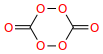

O=C1OOC(=O)OO1
error (GAV - QM) in H298 (kcal/mol):  -105.2000240655526
QM source:  dong_pio_liang.py
GAV source:  Thermo group additivity estimation: group(O2s-O2s(Cds-O2d)) + group(O2s-O2s(Cds-O2d)) + group(O2s-O2s(Cds-O2d)) + group(O2s-O2s(Cds-O2d)) + group(Cds-OdOsOs) + group(Cds-OdOsOs) + ring(14methylenecyclohexane)


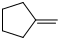

C=C1CCCC1
error (GAV - QM) in H298 (kcal/mol):  -95.14707950297031
QM source:  dong_pio_liang.py
GAV source:  Thermo group additivity estimation: group(Cs-CsCsHH) + group(Cs-CsCsHH) + group(Cs-(Cds-Cds)CsHH) + group(Cs-(Cds-Cds)CsHH) + group(Cds-CdsCsCs) + group(Cds-CdsHH) + ring(methylenecyclopentane)


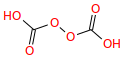

O=C(O)OOC(=O)O
error (GAV - QM) in H298 (kcal/mol):  -46.35848538643134
QM source:  dong_pio_liang.py
GAV source:  Thermo group additivity estimation: group(O2s-O2s(Cds-O2d)) + group(O2s-O2s(Cds-O2d)) + group(O2s-(Cds-O2d)H) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Cds-OdOsOs)


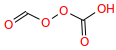

O=COOC(=O)O
error (GAV - QM) in H298 (kcal/mol):  -43.92686197529346
QM source:  dong_pio_liang.py
GAV source:  Thermo group additivity estimation: group(O2s-O2s(Cds-O2d)) + group(O2s-O2s(Cds-O2d)) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Cds-OdOsH)


O=COOC=O
error (GAV - QM) in H298 (kcal/mol):  -41.468860025414344
QM source:  dong_pio_liang.py
GAV source:  Thermo group additivity estimation: group(O2s-O2s(Cds-O2d)) + group(O2s-O2s(Cds-O2d)) + group(Cds-OdOsH) + group(Cds-OdOsH)


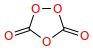

O=C1OOC(=O)O1
error (GAV - QM) in H298 (kcal/mol):  -38.86726921546429
QM source:  dong_pio_liang.py
GAV source:  Thermo group additivity estimation: group(O2s-(Cds-O2d)(Cds-O2d)) + group(O2s-O2s(Cds-O2d)) + group(O2s-O2s(Cds-O2d)) + group(Cds-OdOsOs) + group(Cds-OdOsOs) + ring(Cyclopentane)


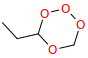

CCC1OCOOO1
error (GAV - QM) in H298 (kcal/mol):  -37.004427064493676
QM source:  johnson_g4.py
GAV source:  Thermo group additivity estimation: group(O2s-CsCs) + group(O2s-OsCs) + group(O2s-OsCs) + group(O2s-OsOs) + group(Cs-CsCsHH) + group(Cs-CsOsOsH) + group(Cs-CsHHH) + group(Cs-OsOsHH) + ring(Cyclohexane)


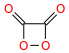

O=C1OOC1=O
error (GAV - QM) in H298 (kcal/mol):  -33.23066571170236
QM source:  dong_pio_liang.py
GAV source:  Thermo group additivity estimation: group(O2s-O2s(Cds-O2d)) + group(O2s-O2s(Cds-O2d)) + group(Cds-O2d(Cds-O2d)O2s) + group(Cds-O2d(Cds-O2d)O2s) + ring(Cyclobutane)


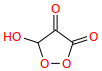

O=C1OOC(O)C1=O
error (GAV - QM) in H298 (kcal/mol):  -33.010576996769686
QM source:  dong_pio_liang.py
GAV source:  Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-O2s(Cds-O2d)) + group(O2s-CsH) + group(Cs-CsOsOsH) + group(Cds-O2d(Cds-O2d)Cs) + group(Cds-O2d(Cds-O2d)O2s) + ring(Cyclopentane)


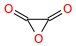

O=C1OC1=O
error (GAV - QM) in H298 (kcal/mol):  28.838565531595066
QM source:  dong_pio_liang.py
GAV source:  Thermo group additivity estimation: group(O2s-(Cds-O2d)(Cds-O2d)) + group(Cds-O2d(Cds-O2d)O2s) + group(Cds-O2d(Cds-O2d)O2s) + ring(cyclopropanedione)


In [20]:
for smi, comment, err_H298, source in list(zip(sorted_error_df.smiles, sorted_error_df.comment, sorted_error_df["H298 (kcal/mol)"], sorted_error_df["source"]))[:10]:
    display(make_mol(smi))
    print(smi)
    print("error (GAV - QM) in H298 (kcal/mol): ", err_H298)
    print("QM source: ", source)
    print("GAV source: ", comment)